<h1> Predicting Drug Approval Status </h1>

---

In [98]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

<h2> 1. Feature Engineering

In [ ]:
trial_drugbank_df = pd.read_csv('./Datasets/Model Training Data.csv')
unseen_trial_drugbank_df = pd.read_csv('./Datasets/Model Unseen Data.csv')

In [100]:
filtered_trial_drugbank_df = trial_drugbank_df.drop_duplicates(subset = ['Clinical Trial Drug'])
filtered_trial_drugbank_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23648 entries, 0 to 69786
Data columns (total 43 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  23648 non-null  int64  
 1   NCT ID                                      23648 non-null  object 
 2   Trial Status                                23648 non-null  object 
 3   Phase                                       23648 non-null  object 
 4   Start Date                                  23648 non-null  object 
 5   Completion Date                             23648 non-null  object 
 6   Trial Duration (Days)                       23648 non-null  int64  
 7   Trial Location                              23648 non-null  object 
 8   Sponsor Name                                23648 non-null  object 
 9   Sponsor Type                                23648 non-null  object 
 10  Treated Conditi

Prediction of drug approval only carried out on unique drugs, because the same drug is used in multiple clinical trials, duplicates of the same drug is dropped.

In [101]:
filtered_unseen_trial_drugbank_df = unseen_trial_drugbank_df.drop_duplicates(subset = ['Clinical Trial Drug'])
filtered_unseen_trial_drugbank_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9630 entries, 0 to 14258
Data columns (total 43 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  9630 non-null   int64  
 1   NCT ID                                      9630 non-null   object 
 2   Trial Status                                9630 non-null   object 
 3   Phase                                       9630 non-null   object 
 4   Start Date                                  9630 non-null   object 
 5   Completion Date                             9630 non-null   object 
 6   Trial Duration (Days)                       9630 non-null   int64  
 7   Trial Location                              9630 non-null   object 
 8   Sponsor Name                                9630 non-null   object 
 9   Sponsor Type                                9630 non-null   object 
 10  Treated Conditio

In [102]:
filtered_trial_drugbank_df['Approval Status'].value_counts()

Approval Status
not approved    22151
approved         1497
Name: count, dtype: int64

In [103]:
filtered_unseen_trial_drugbank_df['Approval Status'].value_counts()

Approval Status
investigational    9630
Name: count, dtype: int64

In [104]:
X = filtered_trial_drugbank_df.iloc[:, -25:]
X

,ATC Class,Medical Condition,Drug-Condition,No. of Trial Locations,Sponsor_Prior Completed Trials,Sponsor_Prior Not Completed Trials,Total COMPLETED PHASE1 Trials per Drug,Total IN-PROGRESS PHASE1 Trials per Drug,Total NOT COMPLETED PHASE1 Trials per Drug,Total COMPLETED PHASE2 Trials per Drug,...,Total ACADEMIC Sponsors per Drug,Total CANCER CENTERS Sponsors per Drug,Total FED Sponsors per Drug,Total HOSPITALS Sponsors per Drug,Total INDUSTRY Sponsors per Drug,Total NETWORK Sponsors per Drug,Total NIH Sponsors per Drug,Total OTHER Sponsors per Drug,Total TOP 10 PHARMA Sponsors per Drug,No. of Medical Conditions Tested per Drug
0,L,Cancer,erlotinib-Cancer,1,10,7,57.0,2.0,17.0,117.0,...,47.0,76.0,0.0,11.0,41.0,5.0,31.0,29.0,15.0,3
1,L,Cancer,gemcitabine-Cancer,1,10,7,133.0,2.0,54.0,270.0,...,131.0,118.0,0.0,68.0,119.0,42.0,25.0,70.0,68.0,4
2,L,Cancer,oxaliplatin-Cancer,1,10,7,48.0,4.0,10.0,122.0,...,66.0,68.0,0.0,27.0,29.0,16.0,21.0,31.0,19.0,3
3,NaN,Metabolic/Endocrine,ar-c165395xx-Metabolic/Endocrine,1,396,46,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,NaN,Cancer,milatuzumab-Cancer,1,84,12,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69780,NaN,Metabolic/Endocrine,bms-686117-Metabolic/Endocrine,1,41,2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
69781,NaN,Metabolic/Endocrine,byetta-Metabolic/Endocrine,1,41,2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
69784,NaN,Cancer,rituximab-chop-Cancer,2,28,9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
69785,NaN,Cancer,rituximab-cvp-Cancer,2,28,9,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


Only features that were aggregated to provide information per drug were being considered for my classifier model.

In [105]:
X_unseen = filtered_unseen_trial_drugbank_df.iloc[:, -25:]
X_unseen

,ATC Class,Medical Condition,Drug-Condition,No. of Trial Locations,Sponsor_Prior Completed Trials,Sponsor_Prior Not Completed Trials,Total COMPLETED PHASE1 Trials per Drug,Total IN-PROGRESS PHASE1 Trials per Drug,Total NOT COMPLETED PHASE1 Trials per Drug,Total COMPLETED PHASE2 Trials per Drug,...,Total ACADEMIC Sponsors per Drug,Total CANCER CENTERS Sponsors per Drug,Total FED Sponsors per Drug,Total HOSPITALS Sponsors per Drug,Total INDUSTRY Sponsors per Drug,Total NETWORK Sponsors per Drug,Total NIH Sponsors per Drug,Total OTHER Sponsors per Drug,Total TOP 10 PHARMA Sponsors per Drug,No. of Medical Conditions Tested per Drug
0,NaN,Mental Health,srx-246-Mental Health,1,4,0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3
1,NaN,Healthy,icp-332 tablets-Healthy,1,0,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
2,NaN,Cancer,chlorine-Cancer,1,20,10,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,NaN,Genetic,regn2477-Genetic,8,68,5,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,NaN,Cancer,gemcitabine-Cancer,1,41,22,133.0,2.0,54.0,270.0,...,131.0,118.0,0.0,68.0,119.0,42.0,25.0,70.0,68.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14251,NaN,Other,atropine sulfate ophthalmic solution usp-Other,1,5,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
14252,NaN,Other,atropine sulfate injection-Other,1,5,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
14253,NaN,Other,usp /20 ml (0.)-Other,1,5,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
14254,NaN,Cancer,tpiv200-Cancer,1,149,13,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


I will be predicting drug approvals from this unseen dataset and will need to carry out the same feature selection treatment on it.

In [106]:
y = filtered_trial_drugbank_df['Approval Status']
y

0            approved
1            approved
2            approved
3        not approved
4        not approved
             ...     
69780    not approved
69781    not approved
69784    not approved
69785    not approved
69786    not approved
Name: Approval Status, Length: 23648, dtype: object

Assign output variable to y.

<h2> 2. Modelling with Decision Tree Classifier

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99) 

In [108]:
dtreeclf = DecisionTreeClassifier(random_state = 99)
dtreeclf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 99,
 'splitter': 'best'}

I will use the Decision Tree Classifier as my first model.

<h3> 2.1. Optimization of feature list to produce highest accuracy

In [109]:
# Feature selection setup
selected_features = []
remaining_features = list(['Total COMPLETED PHASE1 Trials per Drug', 'Total IN-PROGRESS PHASE1 Trials per Drug', 'Total NOT COMPLETED PHASE1 Trials per Drug', 'Total COMPLETED PHASE2 Trials per Drug', 
                           'Total IN-PROGRESS PHASE2 Trials per Drug', 'Total NOT COMPLETED PHASE2 Trials per Drug', 'Total COMPLETED PHASE3 Trials per Drug', 'Total IN-PROGRESS PHASE3 Trials per Drug', 
                           'Total NOT COMPLETED PHASE3 Trials per Drug', 'Total ACADEMIC Sponsors per Drug', 'Total CANCER CENTERS Sponsors per Drug', 'Total FED Sponsors per Drug', 
                           'Total HOSPITALS Sponsors per Drug', 'Total INDUSTRY Sponsors per Drug', 'Total NETWORK Sponsors per Drug', 'Total NIH Sponsors per Drug', 'Total OTHER Sponsors per Drug', 
                            'Total TOP 10 PHARMA Sponsors per Drug', 'No. of Medical Conditions Tested per Drug'])
best_accuracy = 0

while remaining_features:
    improved = False
    feature_to_add = None
    accuracy_with_feature = best_accuracy
    
    # Loop through feature list, train the model on dataset with those features, and output the accuracy metric for evaluation
    for feature in remaining_features:
        trial_features = selected_features + [feature]
        dtreeclf.fit(X_train[trial_features], y_train)
        y_prediction = dtreeclf.predict(X_test[trial_features])
        accuracy = metrics.accuracy_score(y_test, y_prediction)
        
        # If accuracy of model improves, add the feature to list to be added
        if accuracy > accuracy_with_feature:
            accuracy_with_feature = accuracy
            feature_to_add = feature
            improved = True
    
    # Add selected feature to feature list
    if improved:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        best_accuracy = accuracy_with_feature
    else:
        break

print("\nFinal selected features:")
print(selected_features)
print(f"Final Accuracy: {best_accuracy:.3f}")


Final selected features:
['Total ACADEMIC Sponsors per Drug', 'Total OTHER Sponsors per Drug']
Final Accuracy: 0.948


Looped through the entire list of features to select a list of features that has been optimized to give the highest model accuracy score.

In [110]:
X = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99) 

In [111]:
dtreeclf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=99)

In [112]:
y_prediction = dtreeclf.predict(X_test)
report = metrics.classification_report(y_test, y_prediction, output_dict = True)

report_df = pd.DataFrame(report).round(3)
report_df = report_df.drop(['not approved', 'accuracy', 'macro avg', 'weighted avg'], axis = 1)
report_df = report_df.drop('support')
report_df.loc['accuracy'] = [round((metrics.accuracy_score(y_test, y_prediction)), 3)]
report_df = report_df.rename(columns = {'approved' : 'dtree_C'})
report_df

,dtree_C
precision,0.730
recall,0.275
f1-score,0.399
accuracy,0.948


In [113]:
majority_class = y_train.value_counts().index[0]

print(y_train.value_counts())
majority_class

Approval Status
not approved    16614
approved         1122
Name: count, dtype: int64


'not approved'

In [114]:
print(f'Null Accuracy = {round(y_test.value_counts()[majority_class] / y_test.count(), 3)}')

Null Accuracy = 0.937


First model had higher accuracy of 0.953 than null accuracy of 0.935 but recall was quite low at 0.345.

<h3> 2.2. Hyperparameter tuning of Decision Tree Classifier to produce highest accuracy

In [115]:
grid_params = {'criterion': ['gini', 'entropy'], 
                'max_depth': [None] + list(range(5, 15)), 
                'min_samples_split': list(range(2, 20)), 
                'min_samples_leaf': list(range(1, 10)), 
                'max_features': [None, 'sqrt', 'log2'],
                'class_weight': [None],
                'random_state' : [99]} 

grid_search = GridSearchCV(dtreeclf, grid_params, cv = 3, scoring = 'accuracy', n_jobs = -1)

In [116]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=99), n_jobs=-1,
             param_grid={'class_weight': [None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19],
                         'random_state': [99]},
             scoring='accuracy')

Tuning by gridsearchCV to return the hyperparameters that gives the highest accuracy.

In [117]:
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 2, 'random_state': 99}
Best Score: 0.9439557961208841


In [118]:
# Enter best hyperparameters directly into model and fit to avoid re-running GridSearch CV
# dtreeclf = DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 5, max_features = 'sqrt', min_samples_leaf = 9, min_samples_split = 2, random_state = 99)

# dtreeclf.fit(X_train, y_train)

In [119]:
y_predictionA = grid_search.best_estimator_.predict(X_test)
# y_predictionA = dtreeclf.predict(X_test)
reportA = metrics.classification_report(y_test, y_predictionA, output_dict = True)

reportA_df = pd.DataFrame(reportA).round(3)
reportA_df = reportA_df.drop(['not approved', 'accuracy', 'macro avg', 'weighted avg'], axis = 1)
reportA_df = reportA_df.drop('support')
reportA_df.loc['accuracy'] = [round((metrics.accuracy_score(y_test, y_predictionA)), 3)]
reportA_df = reportA_df.rename(columns = {'approved' : 'Atuned_dtree_C'})
reportA_df

,Atuned_dtree_C
precision,0.734
recall,0.301
f1-score,0.427
accuracy,0.949


Tuned model gave higher precision but lower recall. Accuracy was the same.

<h3> 2.3. Optimization of feature list to produce highest recall

In [120]:
X = filtered_trial_drugbank_df.iloc[:, -25:]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99) 

In [121]:
dtreeclf = DecisionTreeClassifier(random_state = 99, class_weight = 'balanced')

In [122]:
# Feature selection setup
selected_features = []
remaining_features = list(['Total COMPLETED PHASE1 Trials per Drug', 'Total IN-PROGRESS PHASE1 Trials per Drug', 'Total NOT COMPLETED PHASE1 Trials per Drug', 'Total COMPLETED PHASE2 Trials per Drug', 
                           'Total IN-PROGRESS PHASE2 Trials per Drug', 'Total NOT COMPLETED PHASE2 Trials per Drug', 'Total COMPLETED PHASE3 Trials per Drug', 'Total IN-PROGRESS PHASE3 Trials per Drug', 
                           'Total NOT COMPLETED PHASE3 Trials per Drug', 'Total ACADEMIC Sponsors per Drug', 'Total CANCER CENTERS Sponsors per Drug', 'Total FED Sponsors per Drug', 
                           'Total HOSPITALS Sponsors per Drug', 'Total INDUSTRY Sponsors per Drug', 'Total NETWORK Sponsors per Drug', 'Total NIH Sponsors per Drug', 'Total OTHER Sponsors per Drug', 
                            'Total TOP 10 PHARMA Sponsors per Drug', 'No. of Medical Conditions Tested per Drug'])
best_recall = 0

while remaining_features:
    improved = False
    feature_to_add = None
    recall_with_feature = best_recall
    
    # Loop through feature list, train the model on dataset with those features, and output the recall metric for evaluation
    for feature in remaining_features:
        trial_features = selected_features + [feature]
        dtreeclf.fit(X_train[trial_features], y_train)
        y_prediction = dtreeclf.predict(X_test[trial_features])
        recall = metrics.recall_score(y_test, y_prediction, pos_label = 'approved')
        
        # If recall of model improves, add the feature to list to be added
        if recall > recall_with_feature:
            recall_with_feature = recall
            feature_to_add = feature
            improved = True
    
    # Add selected feature to feature list
    if improved:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        best_recall = recall_with_feature
    else:
        break

print("\nFinal selected features:")
print(selected_features)
print(f"Final Recall: {best_recall:.3f}")


Final selected features:
['No. of Medical Conditions Tested per Drug', 'Total COMPLETED PHASE3 Trials per Drug', 'Total IN-PROGRESS PHASE1 Trials per Drug']
Final Recall: 0.693


Looped through the entire list of features to select a list of features that has been optimized to give the highest model recall score.

In [123]:
X = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99) 

<h3> 2.4. Hyperparameter tuning of Decision Tree Classifier to produce highest recall

In [124]:
grid_params = {'criterion': ['gini', 'entropy'], 
                'max_depth': [None] + list(range(5, 15)), 
                'min_samples_split': list(range(2, 20)), 
                'min_samples_leaf': list(range(1, 10)), 
                'max_features': [None, 'sqrt', 'log2'],
                'class_weight': ['balanced'],
                'random_state' : [99]} 

grid_search = GridSearchCV(dtreeclf, grid_params, cv = 3, scoring = 'recall', n_jobs = -1)

In [125]:
grid_search.fit(X_train, y_train)

c:\Users\brage\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=99),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19],
                         'random_state': [99]},
             scoring='recall')

Tuning by gridsearchCV to find the hyperparameters that gives the highest recall.

In [126]:
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 99}
Best Score: nan


In [127]:
# Enter best hyperparameters directly into model and fit to avoid re-running GridSearch CV
# dtreeclf = DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = None, max_features = None, min_samples_leaf = 1, min_samples_split = 2, random_state = 99)

# dtreeclf.fit(X_train, y_train)

In [128]:
y_predictionR = grid_search.best_estimator_.predict(X_test)
# y_predictionR = dtreeclf.predict(X_test)
reportR = metrics.classification_report(y_test, y_predictionR, output_dict = True)

reportR_df = pd.DataFrame(reportR).round(3)
reportR_df = reportR_df.drop(['not approved', 'accuracy', 'macro avg', 'weighted avg'], axis = 1)
reportR_df = reportR_df.drop('support')
reportR_df.loc['accuracy'] = [round((metrics.accuracy_score(y_test, y_predictionR)), 3)]
reportR_df = reportR_df.rename(columns = {'approved' : 'Rtuned_dtree_C'})
reportR_df

,Rtuned_dtree_C
precision,0.229
recall,0.693
f1-score,0.345
accuracy,0.833


In [129]:
final_report_df = pd.concat([report_df, reportA_df, reportR_df], axis = 1)
final_report_df

,dtree_C,Atuned_dtree_C,Rtuned_dtree_C
precision,0.730,0.734,0.229
recall,0.275,0.301,0.693
f1-score,0.399,0.427,0.345
accuracy,0.948,0.949,0.833


Overall, after optimizing both the feature list and model hyperparameters to select for the highest recall score, a significantly higher recall score of 0.719 was obtained. <br>

However, precision decreased significantly and accuracy also dropped quite a bit.

<h2> 3. Modelling with Random Forest Classifier

In [130]:
from sklearn.ensemble import RandomForestClassifier

In [131]:
X = filtered_trial_drugbank_df.iloc[:, -25:]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99) 

In [132]:
rforestclf = RandomForestClassifier(random_state = 99)
rforestclf.get_params() # default model parameters

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 99,
 'verbose': 0,
 'warm_start': False}

I will use the Random Forest Classifier as my second model.

<h3> 3.1. Optimization of feature list to produce highest accuracy

In [133]:
# Feature selection setup
selected_features = []
remaining_features = list(['Total COMPLETED PHASE1 Trials per Drug', 'Total IN-PROGRESS PHASE1 Trials per Drug', 'Total NOT COMPLETED PHASE1 Trials per Drug', 'Total COMPLETED PHASE2 Trials per Drug', 
                           'Total IN-PROGRESS PHASE2 Trials per Drug', 'Total NOT COMPLETED PHASE2 Trials per Drug', 'Total COMPLETED PHASE3 Trials per Drug', 'Total IN-PROGRESS PHASE3 Trials per Drug', 
                           'Total NOT COMPLETED PHASE3 Trials per Drug', 'Total ACADEMIC Sponsors per Drug', 'Total CANCER CENTERS Sponsors per Drug', 'Total FED Sponsors per Drug', 
                           'Total HOSPITALS Sponsors per Drug', 'Total INDUSTRY Sponsors per Drug', 'Total NETWORK Sponsors per Drug', 'Total NIH Sponsors per Drug', 'Total OTHER Sponsors per Drug', 
                            'Total TOP 10 PHARMA Sponsors per Drug', 'No. of Medical Conditions Tested per Drug'])
best_accuracy = 0

while remaining_features:
    improved = False
    feature_to_add = None
    accuracy_with_feature = best_accuracy
    
    # Loop through feature list, train the model on dataset with those features, and output the accuracy metric for evaluation
    for feature in remaining_features:
        trial_features = selected_features + [feature]
        rforestclf.fit(X_train[trial_features], y_train)
        y_prediction = rforestclf.predict(X_test[trial_features])
        accuracy = metrics.accuracy_score(y_test, y_prediction)
        
        # If accuracy of model improves, add the feature to list to be added
        if accuracy > accuracy_with_feature:
            accuracy_with_feature = accuracy
            feature_to_add = feature
            improved = True
    
    # Add selected feature to feature list
    if improved:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        best_accuracy = accuracy_with_feature
    else:
        break

print("\nFinal selected features:")
print(selected_features)
print(f"Final Accuracy: {best_accuracy:.3f}")


Final selected features:
['Total ACADEMIC Sponsors per Drug', 'Total OTHER Sponsors per Drug', 'Total INDUSTRY Sponsors per Drug', 'Total IN-PROGRESS PHASE1 Trials per Drug', 'Total NETWORK Sponsors per Drug']
Final Accuracy: 0.950


Looped through the entire list of features to select a list of features that has been optimized to give the highest model accuracy score.

In [134]:
X = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99) 

In [135]:
rforestclf.fit(X_train, y_train)

RandomForestClassifier(random_state=99)

In [136]:
y_prediction2 = rforestclf.predict(X_test)
report2 = metrics.classification_report(y_test, y_prediction2, output_dict = True)

report2_df = pd.DataFrame(report2).round(3)
report2_df = report2_df.drop(['not approved', 'accuracy', 'macro avg', 'weighted avg'], axis = 1)
report2_df = report2_df.drop('support')
report2_df.loc['accuracy'] = [round((metrics.accuracy_score(y_test, y_prediction2)), 3)]
report2_df = report2_df.rename(columns = {'approved' : 'rforest_C'})
report2_df

,rforest_C
precision,0.723
recall,0.355
f1-score,0.476
accuracy,0.950


Random forest classifier had slightly better precision than the decision tree classifier, before the hyperparameter tuning.

<h3> 3.2. Hyperparameter tuning of Random Forest Classifier to produce highest accuracy

In [137]:
grid_params = {'n_estimators': [100],
                'criterion': ['gini', 'entropy'], 
                'max_depth': [None] + list(range(5, 10)), 
                'min_samples_split': list(range(2, 20)),
                'min_samples_leaf': list(range(1, 5)), 
                'max_features': ['sqrt', 'log2'],
                'class_weight': [None],
                'random_state' : [99]} 

grid_search = GridSearchCV(rforestclf, grid_params, cv = 3, scoring = 'accuracy', n_jobs = -1)

In [138]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=99), n_jobs=-1,
             param_grid={'class_weight': [None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19],
                         'n_estimators': [100], 'random_state': [99]},
             scoring='accuracy')

Tuning by gridsearchCV to return the hyperparameters that gives the highest accuracy.

In [139]:
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 16, 'n_estimators': 100, 'random_state': 99}
Best Score: 0.9470004510599909


In [140]:
# Enter best hyperparameters directly into model and fit to avoid re-running GridSearch CV
# rforestclf = RandomForestClassifier(class_weight = None, criterion = 'entropy', max_depth = 6, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 7, n_estimators = 100, random_state = 99)

# rforestclf.fit(X_train, y_train)

In [141]:
y_prediction2A = grid_search.best_estimator_.predict(X_test)
# y_prediction2A = rforestclf.predict(X_test)
report2A = metrics.classification_report(y_test, y_prediction2A, output_dict = True)

report2A_df = pd.DataFrame(report2A).round(3)
report2A_df = report2A_df.drop(['not approved', 'accuracy', 'macro avg', 'weighted avg'], axis = 1)
report2A_df = report2A_df.drop('support')
report2A_df.loc['accuracy'] = [round((metrics.accuracy_score(y_test, y_prediction2A)), 3)]
report2A_df = report2A_df.rename(columns = {'approved' : 'ATuned_rforest_C'})
report2A_df

,ATuned_rforest_C
precision,0.793
recall,0.285
f1-score,0.420
accuracy,0.950


The random forest model that was tuned to achieve the highest accuracy produced higher precision but lower recall, and similar accuracy.

<h3> 3.3. Optimization of feature list to produce highest recall

In [142]:
X = filtered_trial_drugbank_df.iloc[:, -25:]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99) 

In [143]:
rforestclf = RandomForestClassifier(random_state = 99, class_weight = 'balanced')

In [144]:
# Feature selection setup
selected_features = []
remaining_features = list(['Total COMPLETED PHASE1 Trials per Drug', 'Total IN-PROGRESS PHASE1 Trials per Drug', 'Total NOT COMPLETED PHASE1 Trials per Drug', 'Total COMPLETED PHASE2 Trials per Drug', 
                           'Total IN-PROGRESS PHASE2 Trials per Drug', 'Total NOT COMPLETED PHASE2 Trials per Drug', 'Total COMPLETED PHASE3 Trials per Drug', 'Total IN-PROGRESS PHASE3 Trials per Drug', 
                           'Total NOT COMPLETED PHASE3 Trials per Drug', 'Total ACADEMIC Sponsors per Drug', 'Total CANCER CENTERS Sponsors per Drug', 'Total FED Sponsors per Drug', 
                           'Total HOSPITALS Sponsors per Drug', 'Total INDUSTRY Sponsors per Drug', 'Total NETWORK Sponsors per Drug', 'Total NIH Sponsors per Drug', 'Total OTHER Sponsors per Drug', 
                            'Total TOP 10 PHARMA Sponsors per Drug', 'No. of Medical Conditions Tested per Drug'])
best_recall = 0

while remaining_features:
    improved = False
    feature_to_add = None
    recall_with_feature = best_recall
    
    # Loop through feature list, train the model on dataset with those features, and output the recall metric for evaluation
    for feature in remaining_features:
        trial_features = selected_features + [feature]
        rforestclf.fit(X_train[trial_features], y_train)
        y_prediction = rforestclf.predict(X_test[trial_features])
        recall = metrics.recall_score(y_test, y_prediction, pos_label = 'approved')
        
        # If recall of model improves, add the feature to list to be added
        if recall > recall_with_feature:
            recall_with_feature = recall
            feature_to_add = feature
            improved = True
    
    # Add selected feature to feature list
    if improved:
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        best_recall = recall_with_feature
    else:
        break

print("\nFinal selected features:")
print(selected_features)
print(f"Final Recall: {best_recall:.3f}")


Final selected features:
['No. of Medical Conditions Tested per Drug', 'Total COMPLETED PHASE3 Trials per Drug', 'Total IN-PROGRESS PHASE1 Trials per Drug', 'Total IN-PROGRESS PHASE3 Trials per Drug', 'Total FED Sponsors per Drug']
Final Recall: 0.712


Looped through the entire list of features to select a list of features that has been optimized to give the highest model recall score.

In [145]:
X = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99) 

<h3> 3.4. Hyperparameter tuning of Random Forest Classifier to produce highest recall

In [146]:
grid_params = {'n_estimators': [100],
                'criterion': ['gini', 'entropy'], 
                'max_depth': [None] + list(range(5, 10)), 
                'min_samples_split': list(range(2, 20)),
                'min_samples_leaf': list(range(1, 5)), 
                'max_features': ['sqrt', 'log2'],
                'class_weight': ['balanced'],
                'random_state' : [99]} 

In [147]:
grid_search = GridSearchCV(rforestclf, grid_params, cv = 3, scoring = 'recall', n_jobs = -1)

In [148]:
grid_search.fit(X_train, y_train)

c:\Users\brage\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\brage\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=99),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19],
                         'n_estimators': [100], 'random_state': [99]},
             scoring='recall')

Tuning by gridsearchCV to return the hyperparameters that gives the highest recall.

In [149]:
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 99}
Best Score: nan


In [150]:
# Enter best hyperparameters directly into model and fit to avoid re-running GridSearch CV
# rforestclf = RandomForestClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = None, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100, random_state = 99)

# rforestclf.fit(X_train, y_train)

In [151]:
y_prediction2R = grid_search.best_estimator_.predict(X_test)
# y_prediction2R = rforestclf.predict(X_test)
report2R = metrics.classification_report(y_test, y_prediction2R, output_dict = True)

report2R_df = pd.DataFrame(report2R).round(3)
report2R_df = report2R_df.drop(['not approved', 'accuracy', 'macro avg', 'weighted avg'], axis = 1)
report2R_df = report2R_df.drop('support')
report2R_df.loc['accuracy'] = [round((metrics.accuracy_score(y_test, y_prediction2R)), 3)]
report2R_df = report2R_df.rename(columns = {'approved' : 'Rtuned_rforest_C'})
report2R_df

,Rtuned_rforest_C
precision,0.234
recall,0.712
f1-score,0.352
accuracy,0.834


The random forest model that was tuned to achieve the highest recall produced higher recall but much lower precision and slightly lower accuracy.

In [152]:
final_report2_df = pd.concat([report2_df, report2A_df, report2R_df], axis = 1)
final_report2_df

,rforest_C,ATuned_rforest_C,Rtuned_rforest_C
precision,0.723,0.793,0.234
recall,0.355,0.285,0.712
f1-score,0.476,0.420,0.352
accuracy,0.950,0.950,0.834


In [153]:
final_report_df

,dtree_C,Atuned_dtree_C,Rtuned_dtree_C
precision,0.730,0.734,0.229
recall,0.275,0.301,0.693
f1-score,0.399,0.427,0.345
accuracy,0.948,0.949,0.833


Random Forest Classifier that was optimized based on the recall metric produced the highest recall score of 0.724 out of all models but much lower precision of 0.246 and accuracy of 0.845. <br>
Decision Tree Classifier that was optimized based on the accuracy metric produced the highest accuracy and precision scores of 0.953 and 0.794, respectively, but much lower recall of 0.323. <br>

In this scenario, having lower precision means have more drugs predicted to be approved, which ends up not getting approved. The company suffers losses in terms of the cost of drug development. <br>
Having lower recall means having more drugs predicted to be not approved, which ends up getting approved. The company suffers losses in terms of the potential profit from selling the approved drug. <br>

In terms of financial incentive, the profit outweighs the cost of development and recall is considered to be a more important metric. <br>

Therefore, the recall-tuned random forest was chosen as my model for predicting drug approval of unseen trial data.

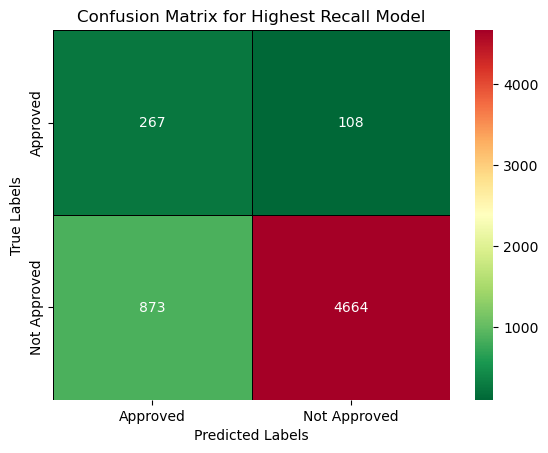

In [154]:
cm_bank_model = confusion_matrix(y_test, y_prediction2R)

class_names = ['Approved','Not Approved']
fig1 = plt.figure()
sns.heatmap(cm_bank_model, annot = True, fmt = 'd', cmap = 'RdYlGn_r', xticklabels = class_names, yticklabels = class_names, linewidths = 0.5, linecolor = 'black')
plt.title('Confusion Matrix for Highest Recall Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

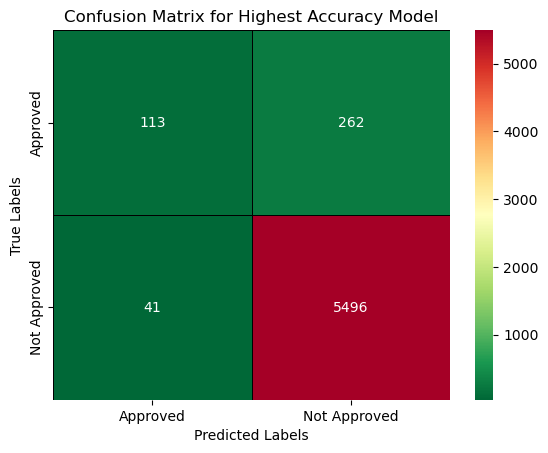

In [155]:
cm_bank_model = confusion_matrix(y_test, y_predictionA)

class_names = ['Approved','Not Approved']
fig2 = plt.figure()
sns.heatmap(cm_bank_model, annot = True, fmt = 'd', cmap = 'RdYlGn_r', xticklabels = class_names, yticklabels = class_names, linewidths = 0.5, linecolor = 'black')
plt.title('Confusion Matrix for Highest Accuracy Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Comparing the confusion matrices, the number of true positives were significantly higher at 294 for the highest recall model as compared to the highest accuracy model at 131.

<h2> 4. Predicting Drug Approval Status of Clinical Trials under Investigational Status

In [156]:
X = X[selected_features]

In [157]:
grid_params = {'n_estimators': [100],
                'criterion': ['gini', 'entropy'], 
                'max_depth': [None] + list(range(5, 10)), 
                'min_samples_split': list(range(2, 20)),
                'min_samples_leaf': list(range(1, 5)), 
                'max_features': ['sqrt', 'log2'],
                'class_weight': ['balanced'],
                'random_state' : [99]} 

In [158]:
grid_search = GridSearchCV(rforestclf, grid_params, cv = 3, scoring = 'recall', n_jobs = -1)

In [159]:
grid_search.fit(X, y)

c:\Users\brage\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=99),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19],
                         'n_estimators': [100], 'random_state': [99]},
             scoring='recall')

The entire dataset, not just X_train and y_train, was fitted onto the random forest model and feature selection optimized for highest recall.

In [160]:
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 99}
Best Score: nan


In [161]:
# Use optimized parameters for accuracy to re-train the random forest model with full X and y dataset
# rforestclf = RandomForestClassifier(class_weight = None, criterion = 'entropy', max_depth = None, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 8, n_estimators = 100, random_state = 99)

# rforestclf.fit(X, y)

In [162]:
X_unseen = X_unseen[selected_features]

The feature list optimized to produce the highest recall was selected for the unseen data as well.

In [163]:
# y_prediction = rforestclf.predict(X_unseen)
y_prediction = grid_search.best_estimator_.predict(X_unseen)
y_prediction

array(['approved', 'approved', 'not approved', ..., 'not approved',
       'not approved', 'approved'], dtype=object)

In [164]:
drug_approval_predictions_df = filtered_unseen_trial_drugbank_df
drug_approval_predictions_df['Predicted Status'] = y_prediction
drug_approval_predictions_df = drug_approval_predictions_df[['Clinical Trial Drug', 'Predicted Status']]

drug_approval_predictions_df = pd.merge(unseen_trial_drugbank_df, drug_approval_predictions_df, on = 'Clinical Trial Drug', how = 'left')
drug_approval_predictions_df

C:\Users\brage\AppData\Local\Temp\ipykernel_29296\3712859053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_approval_predictions_df['Predicted Status'] = y_prediction


,Unnamed: 0,NCT ID,Trial Status,Phase,Start Date,Completion Date,Trial Duration (Days),Trial Location,Sponsor Name,Sponsor Type,...,Total CANCER CENTERS Sponsors per Drug,Total FED Sponsors per Drug,Total HOSPITALS Sponsors per Drug,Total INDUSTRY Sponsors per Drug,Total NETWORK Sponsors per Drug,Total NIH Sponsors per Drug,Total OTHER Sponsors per Drug,Total TOP 10 PHARMA Sponsors per Drug,No. of Medical Conditions Tested per Drug,Predicted Status
0,3,NCT02922166,IN-PROGRESS,PHASE1,2017-02-01,2019-12-01,1033,United States,Azevan Pharmaceuticals,INDUSTRY,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3,approved
1,4,NCT06530966,IN-PROGRESS,PHASE1,2024-07-01,2024-12-01,153,United States,InnoCare Pharma Inc.,INDUSTRY,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,approved
2,10,NCT03602066,NOT COMPLETED,PHASE2,2019-02-01,2022-11-01,1369,United States,University of Arizona,ACADEMIC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,not approved
3,11,NCT03188666,COMPLETED,PHASE2,2018-02-01,2021-09-01,1308,"United States, Canada, France, Italy, Netherla...",Regeneron Pharmaceuticals,INDUSTRY,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,not approved
4,13,NCT03101566,COMPLETED,PHASE2,2017-09-01,2021-06-01,1369,United States,University of Michigan Rogel Cancer Center,ACADEMIC,...,118.0,0.0,68.0,119.0,42.0,25.0,70.0,68.0,4,approved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14256,84029,NCT01036087,COMPLETED,PHASE2,2010-11-01,2022-08-01,4291,United States,M.D. Anderson Cancer Center,CANCER CENTERS,...,21.0,0.0,6.0,23.0,4.0,3.0,8.0,17.0,3,not approved
14257,84032,NCT04998487,COMPLETED,PHASE1,2021-08-01,2022-07-01,334,United States,Nektar Therapeutics,INDUSTRY,...,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,4,approved
14258,84047,NCT01682187,COMPLETED,PHASE1,2005-12-01,2024-09-01,6849,"United States, Spain",Eli Lilly and Company,TOP 10 PHARMA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3,approved
14259,84048,NCT01682187,COMPLETED,PHASE1,2005-12-01,2024-09-01,6849,"United States, Spain",Eli Lilly and Company,TOP 10 PHARMA,...,7.0,0.0,2.0,3.0,6.0,0.0,1.0,6.0,2,approved


In [ ]:
drug_approval_predictions_df.to_csv('./Datasets/Drug Approval Predictions.csv', index = False)

The predictions for drug approval status were added to the unseen dataset and exported.

The final objective will be to use these predictions to generate a forecast of approved drugs from 2025 to 2028.

In [ ]:
# fig1.savefig("./Exported figures/fig2.1.png", dpi = 300, bbox_inches = 'tight')
# fig2.savefig("./Exported figures/fig2.2.png", dpi = 300, bbox_inches = 'tight')